In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

In [2]:
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### PREPROCESSING

In [4]:
#check for nan values
diabetes_df.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [5]:
#check for zero values in specific columns
check_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
zero_count = diabetes_df[check_zero].eq(0).sum()
print(zero_count)

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [6]:
#drop columns with too many zero values:
diabetes_df = diabetes_df.drop(['SkinThickness', 'Insulin'], axis=1)

In [7]:
#replace zero values with median:
zero_val_columns = ['Glucose','BloodPressure','BMI']
diabetes_df[zero_val_columns]=diabetes_df[zero_val_columns].replace(0,diabetes_df[zero_val_columns].median())

#### EXPLORATORY PLOTS

In [66]:
def plot_bar_chart(x, y, title="Bar Chart", xticks_label="", xlabel="Categories", ylabel="Values"):
    """
    Plots a bar chart
    """
    #create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(x, y)

    #add labels and title
    plt.title(title, fontsize=16)
    plt.xticks(ticks=range(len(x)), labels=x)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

     #add labels on top of the bars
    for i, value in enumerate(y):
        plt.text(i, value + 0.5, str(value), ha='center', fontsize=10)
        
    plt.savefig('bar.png')
    plt.show()

Outcome
0    500
1    268
Name: count, dtype: int64


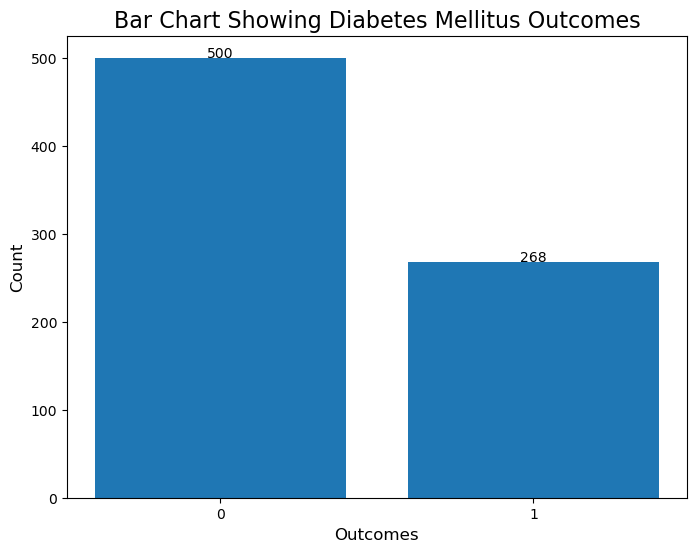

In [68]:
#plot a bar chart showing the outcome counts:
outcome_counts = diabetes_df['Outcome'].value_counts()
print(outcome_counts)
plot_bar_chart(outcome_counts.index, outcome_counts.values, xticks_label=outcome_counts.index, title="Bar Chart Showing Diabetes Mellitus Outcomes",  xlabel="Outcomes", ylabel="Count")

In [62]:
def plot_scatter(title, x, y, outcome):
    """
    Takes x and y parameters to plot a scatter plot
    """
    plt.figure(figsize=(8, 6))
    
    #plot scatter
    scatter = plt.scatter(x, y,  c=outcome, cmap='plasma', label=outcome)

    #get unique categories to add to legend
    categories = np.unique(outcome)
    legend_labels = [str(category) for category in categories]

    #title
    plt.title(title, fontsize=16)
    
    # add legend
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Outcome Categories", loc="upper right")

    #formatting
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.savefig('scatter.png')
    plt.show()
    return

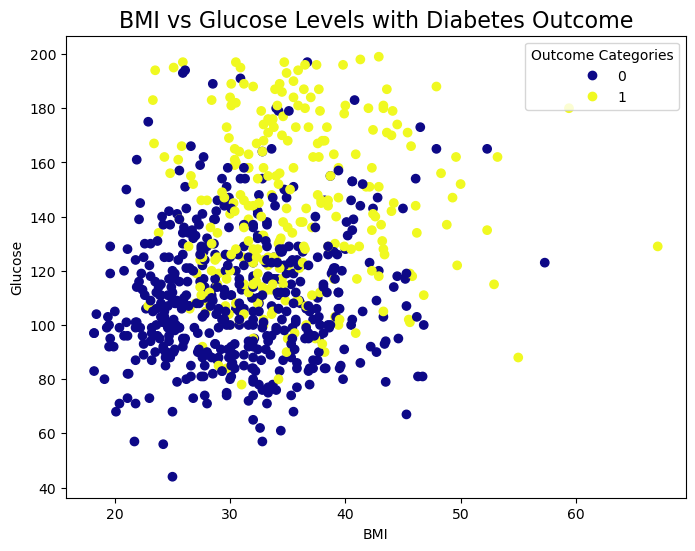

In [64]:
x = diabetes_df['BMI']
y = diabetes_df['Glucose']
title = 'BMI vs Glucose Levels with Diabetes Outcome'
outcome = diabetes_df['Outcome'] 
plot_scatter(title, x, y, outcome)

In [70]:
def plot_correlation(df, method):
    """
    Plots a correlation heatmap,
    taking the dataframe and method as parameters
    """

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(df.corr(method=method), ax=ax, annot=True, annot_kws={"size": 8}, fmt=".2f", cmap='viridis')
    
    # change label font size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(method.capitalize())
    plt.savefig('corr.png', bbox_inches='tight')
    plt.show()
    return

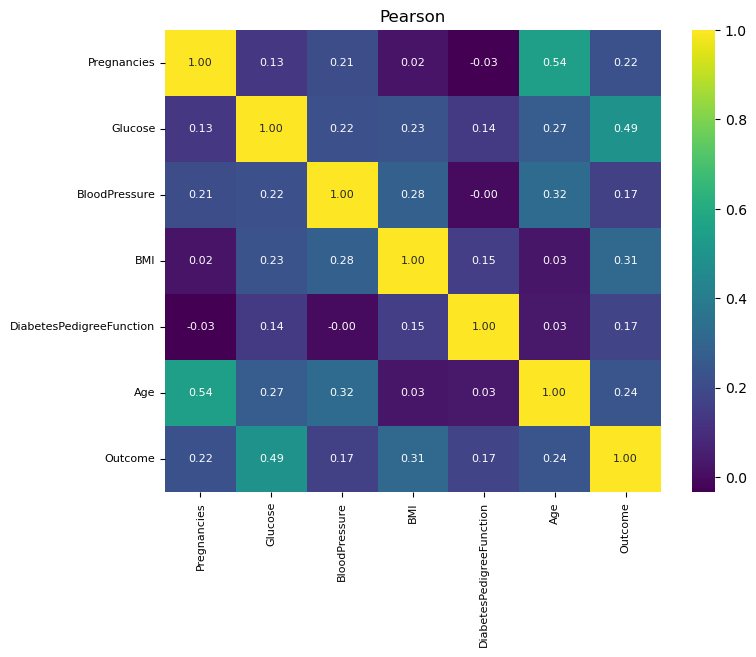

In [72]:
plot_correlation(diabetes_df, 'pearson')

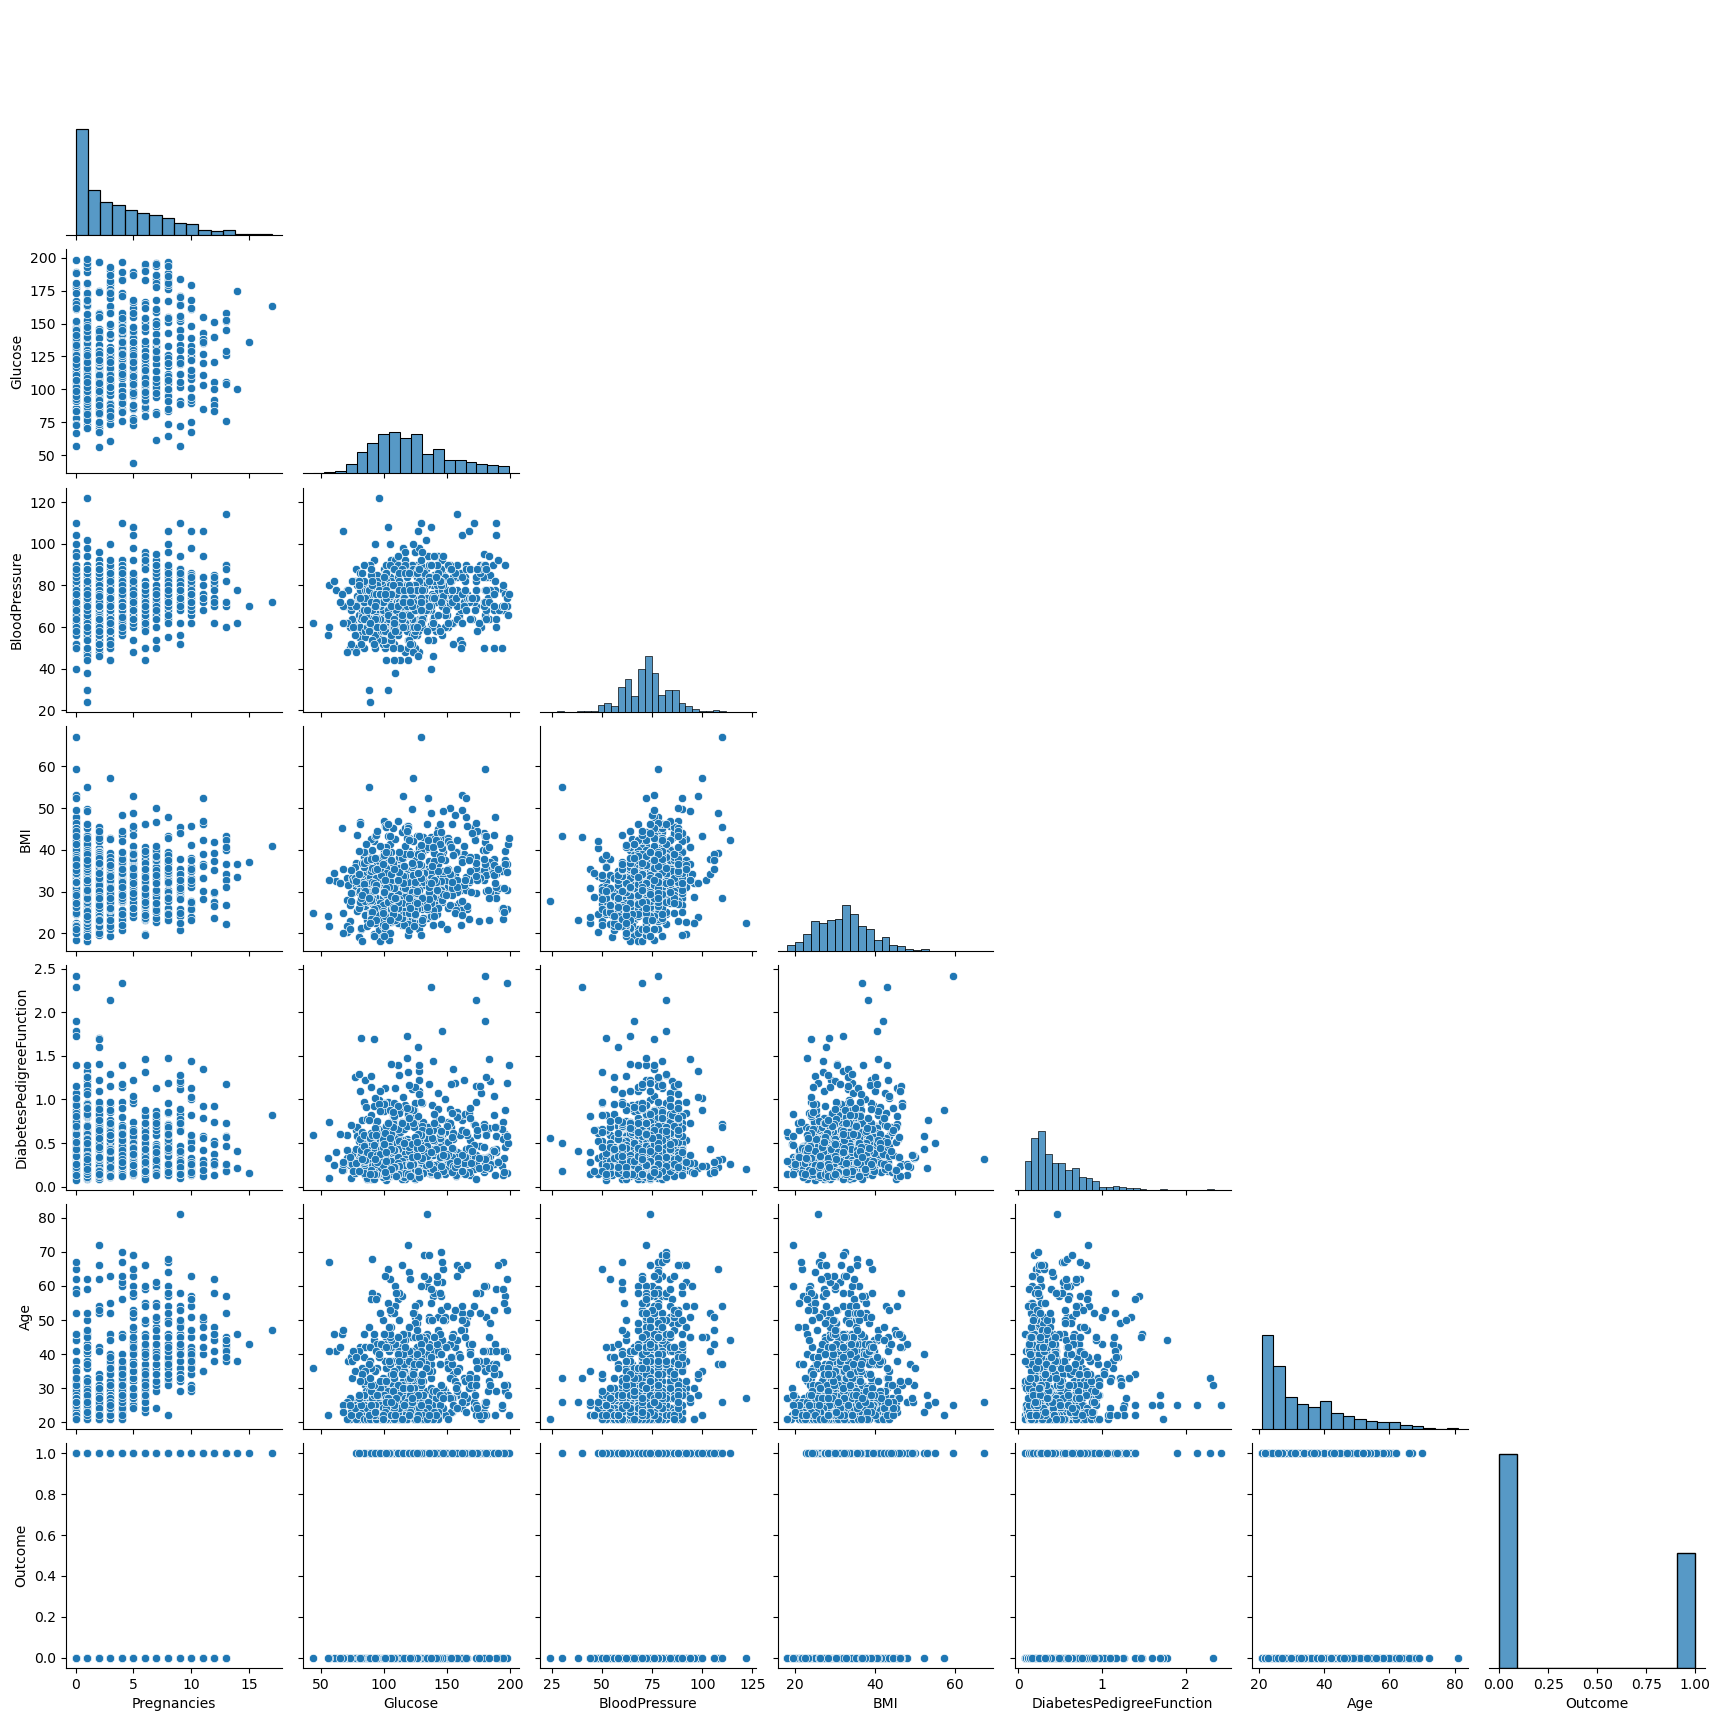

<Figure size 921.6x691.2 with 0 Axes>

In [15]:
sns.pairplot(diabetes_df, corner=True)
plt.figure(dpi=144)
plt.show()

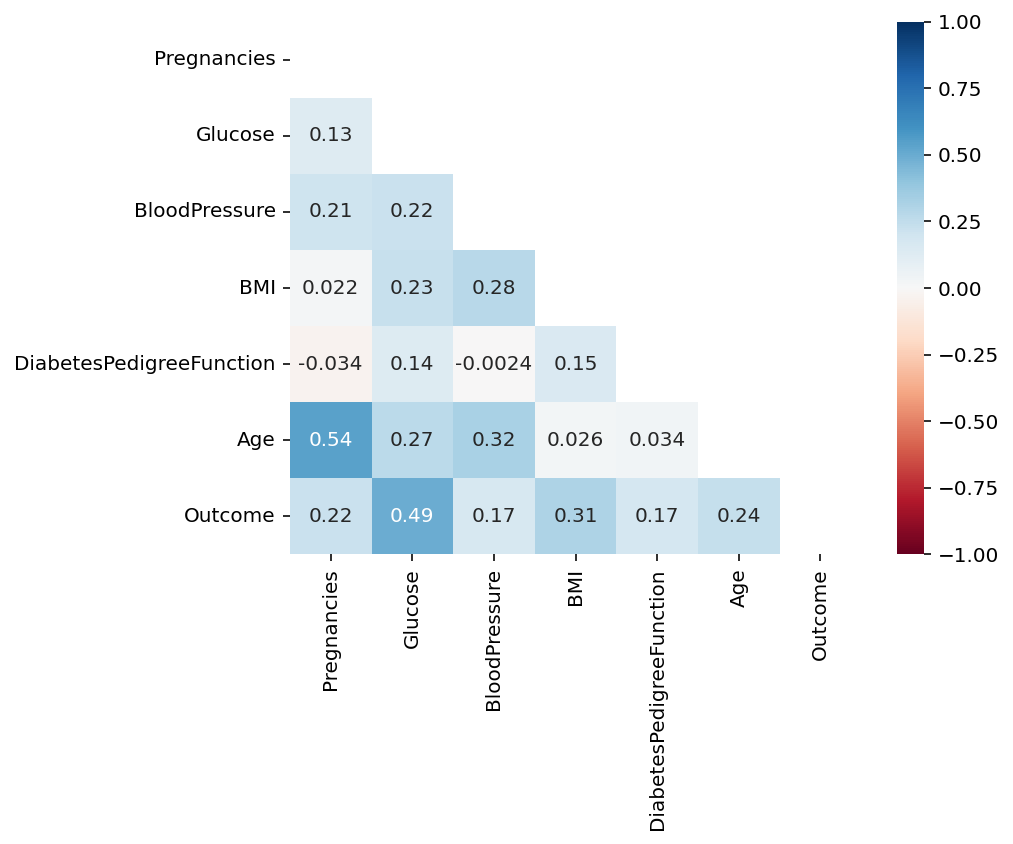

In [16]:
 fig, ax = plt.subplots(dpi=144)
mask = np.triu(np.ones_like(diabetes_df.corr()))
sns.heatmap(diabetes_df.corr(), ax=ax, vmin=-1, vmax=1, cmap='RdBu', annot=True, mask=mask)
plt.show()

#### CLUSTERING

In [18]:
#normalise the data
scaler = RobustScaler()
diabetes_df_sub = diabetes_df[['Glucose', 'BMI']].copy()
diabetes_df_norm = scaler.fit_transform(diabetes_df_sub)

In [19]:
diabetes_df_sub.head()

,Glucose,BMI
0,148,33.6
1,85,26.6
2,183,23.3
3,89,28.1
4,137,43.1


In [20]:
print(diabetes_df_norm)

[[ 0.7654321   0.17582418]
 [-0.79012346 -0.59340659]
 [ 1.62962963 -0.95604396]
 ...
 [ 0.09876543 -0.63736264]
 [ 0.22222222 -0.20879121]
 [-0.59259259 -0.17582418]]


In [21]:
def plot_elbow(data, k_min, k_max, best_n):
    """
    Function that takes the dataframe, min and max number of clusters to create
    elbow plot to determine the optimal number of clusters for KMeans.

    """
    #compute WCSS for elbow plot
    k_values = range(k_min, k_max + 1)
    wcss = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=20)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    #plot the elbow curve
    plt.plot(k_values, wcss, 'kx-')
    plt.scatter(best_n, wcss[best_n-k_min], marker='o', color='red',facecolors='none', s=50)
    plt.title('Elbow Plot')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.savefig('elbow.png')
    plt.show()


In [22]:
def silhoutte_inertia(n, data):
    """
    Calculates the silhoutte score and WCSS for n clusters
    """
    #set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters=n, n_init=20)
    #fit the data
    kmeans.fit(data)
    labels = kmeans.labels_
    #calculate the silhoutte score
    score = silhouette_score(data, labels)
    inertia = kmeans.inertia_
    return score, inertia

 2 clusters silhoutte score = 0.38
 3 clusters silhoutte score = 0.37
 4 clusters silhoutte score = 0.36
 5 clusters silhoutte score = 0.34
 6 clusters silhoutte score = 0.34
 7 clusters silhoutte score = 0.34
 8 clusters silhoutte score = 0.34
 9 clusters silhoutte score = 0.34
10 clusters silhoutte score = 0.34
Best number of clusters =  2


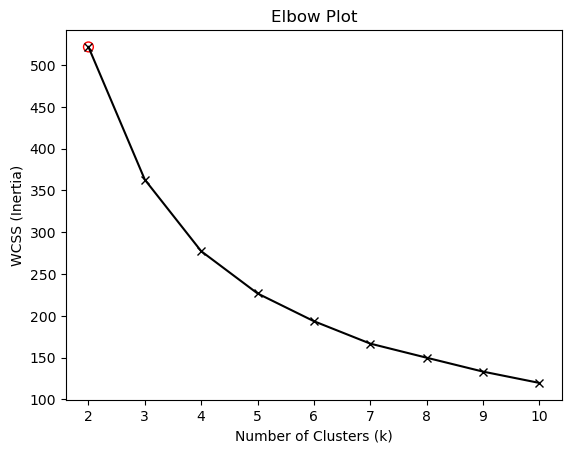

In [23]:
best_n, best_score = None, -np.inf

for n in range(2, 11): # 1 to 10 clusters
    score, inertia = silhoutte_inertia(n, diabetes_df_norm)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")
    
print(f"Best number of clusters = {best_n:2g}")
plot_elbow(diabetes_df_norm, 2, 10, best_n)

In [24]:
def plot_fitted_glucose_BMI(labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)
    fig, ax = plt.subplots(dpi=144)
    s = ax.scatter(xy[:, 0], xy[:, 1], c=labels, cmap=cmap, marker='o', s=10, alpha=0.5, label='Data')
    ax.scatter(xkmeans, ykmeans, c=centre_labels, cmap=cmap, marker='x', s=100, label='Estimated Centres')
    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(labels))
    ax.legend()
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BM1')
    plt.show()
    return

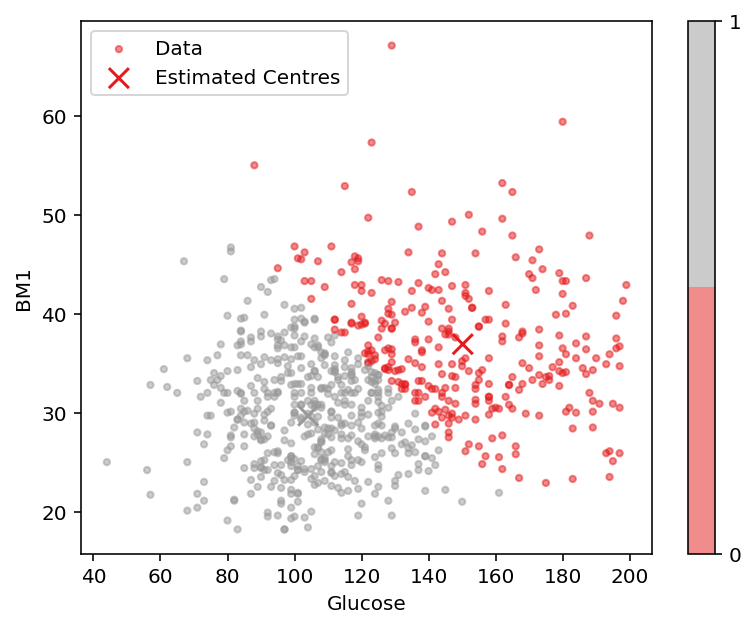

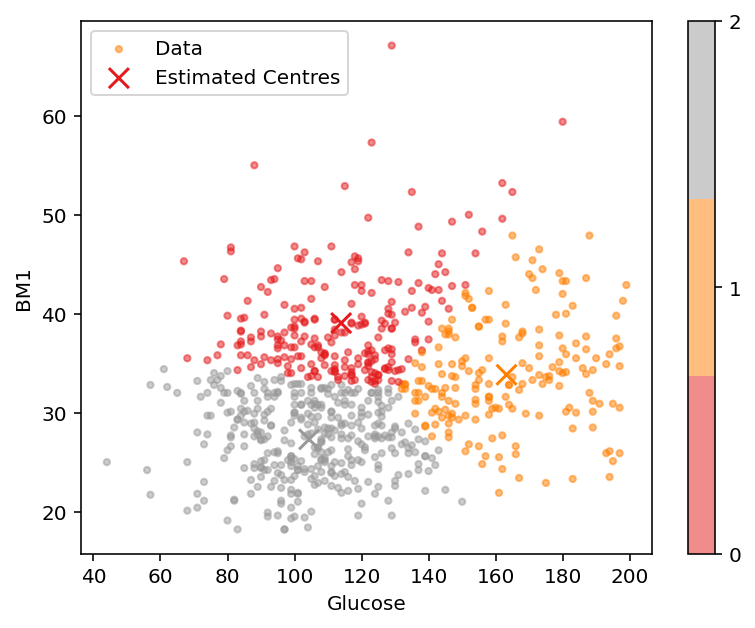

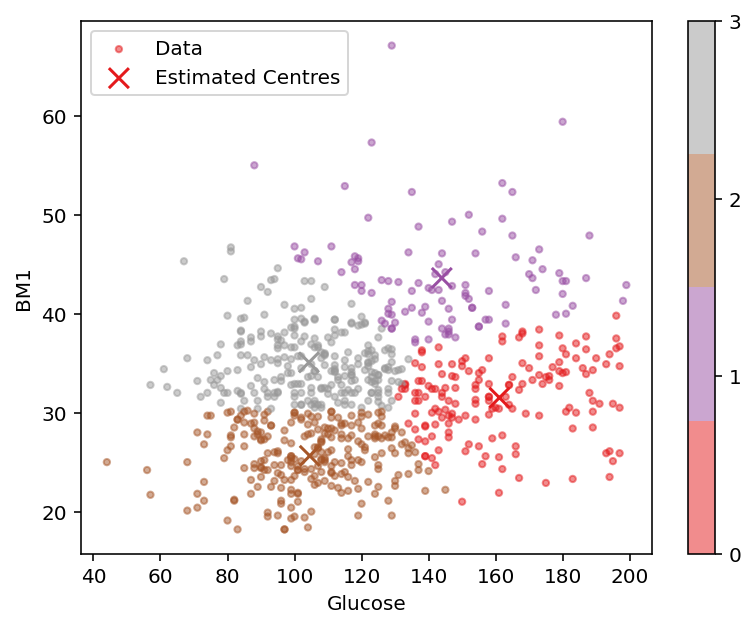

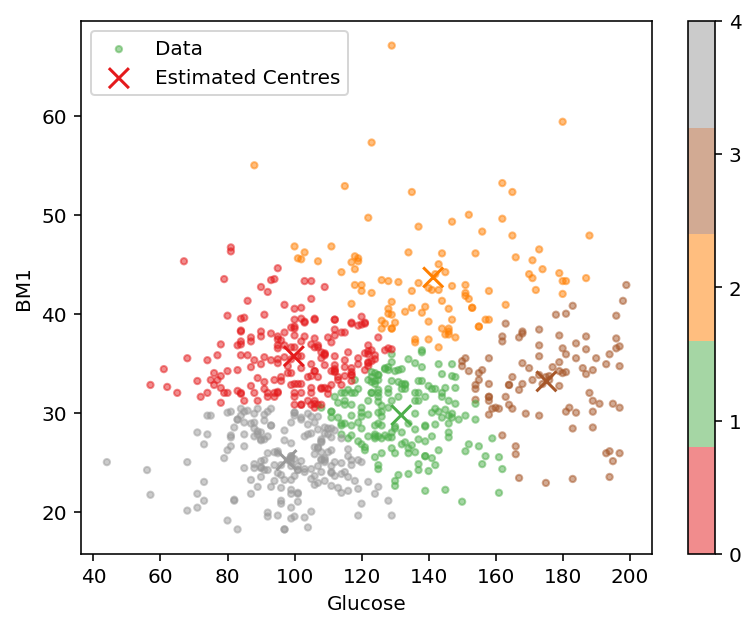

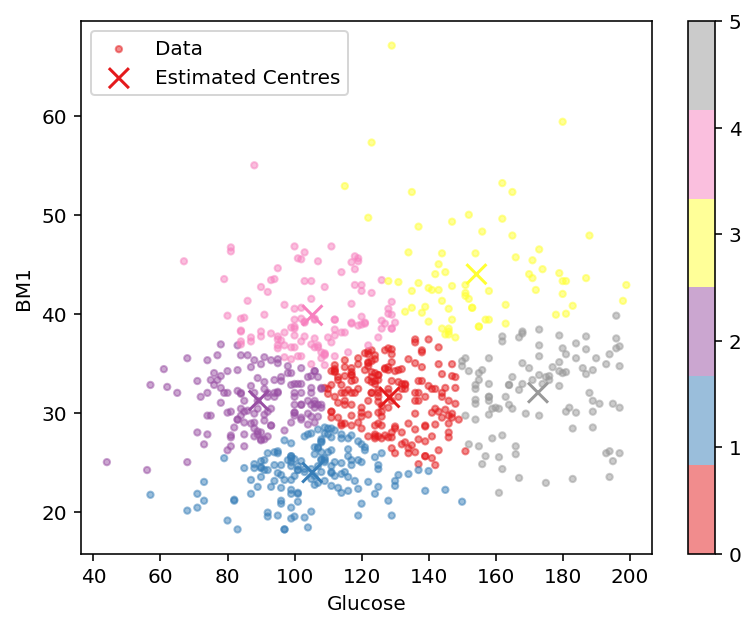

In [25]:
inv_norm = scaler.inverse_transform(diabetes_df_norm)
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(diabetes_df_norm)
    labels = kmeans.labels_
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_fitted_glucose_BMI(labels, inv_norm, xkmeans, ykmeans, cenlabels)

#### FITTING

In [27]:
def plot_logistic_regression_curve(data, feature, target):
    """
    This function takes the data, feature variable and target variable,
    fits a logistic regression model to data and plots the logistic regression curve.
    
    """
    # Sort the data by the feature
    sorted_data = data.sort_values(by=feature)
    X_sorted = sorted_data[[feature]]
    y_sorted = sorted_data[target]

    # Fit the logistic regression model
    model = LogisticRegression()
    model.fit(data[[feature]], data[target])

    # Predict probabilities using the sorted feature
    sorted_probabilities = model.predict_proba(X_sorted)[:, 1]

    # Plot the scatter points and logistic regression curve
    plt.figure(figsize=(8, 6))
    plt.scatter(X_sorted, y_sorted, color='blue', alpha=0.6, label='Data Points')
    plt.plot(X_sorted, sorted_probabilities, color='red', label='Logistic Curve')
    plt.title("Logistic Curve of Probability of Outcome = 1 given BMI values")
    plt.xlabel(feature)
    plt.ylabel(f"Probability of {target} = 1")
    plt.legend()
    plt.show()

    return model


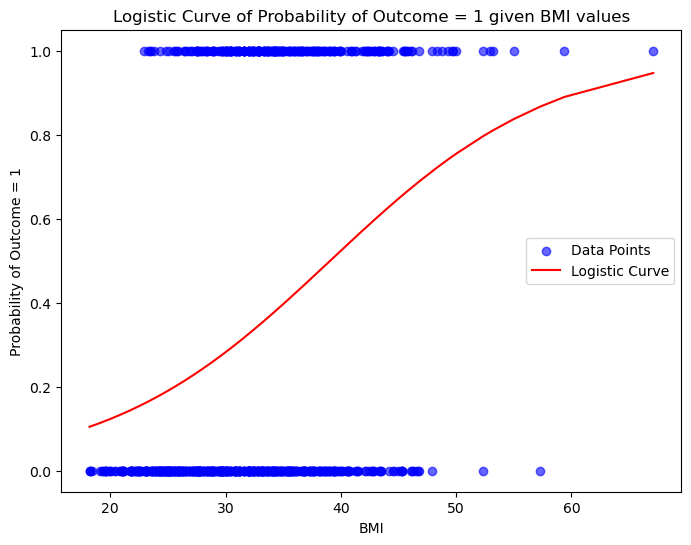

In [28]:
# Call the function with your DataFrame
model = plot_logistic_regression_curve(data=diabetes_df, feature='BMI', target='Outcome')
